## Basic Setup

In [1]:
import sys
sys.path.append("/usr/local/lib/python3.5/site-packages/")

In [2]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt

mp.quiet(quietval=True)
seed = 24
np.random.seed(seed)

resolution = 10

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-1,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)

source = [mp.Source(src,component=mp.Ez,
                    size = source_size,
                    center=source_center)]


design_region_resolution = 10

design_region = mp.Volume(center=mp.Vector3(), size=mp.Vector3(1, 1, 0))
design_variables = mpa.BilinearInterpolationBasis(volume=design_region,resolution=design_region_resolution)

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=mp.Medium(index=3.45), size=mp.Vector3(Sx/2, 0.5, 0)), # horizontal waveguide
    mp.Block(center=mp.Vector3(y=Sy/4), material=mp.Medium(index=3.45), size=mp.Vector3(0.5, Sy/2, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, epsilon_func=design_variables.func()) # design region
]


sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)


Ez0 = mpa.E_Coefficients(sim,mp.Volume(center=mp.Vector3(0,1,0),size=mp.Vector3(2,0,0)), mp.Ez)
ob_list = [Ez0]




def J1(alpha):
    return npa.abs(alpha[0,2])**2 #+ 3*npa.abs(alpha[1,4])**2 #+ npa.abs(alpha[2,0])**2
def J2(alpha):
    return npa.abs(alpha[1,4])**2 + 6*npa.abs(alpha[2,7])**2
def J3(alpha):
    return npa.sum(npa.abs(alpha)**2)


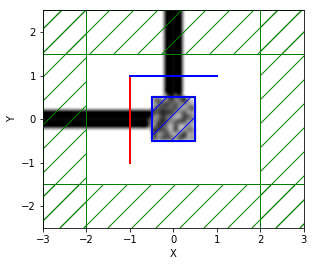

In [3]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J1,
    objective_arguments=ob_list,
    design_variables=[design_variables],
    fcen=fcen,
    df = 0.03,
    nf = 3,
    decay_fields=[mp.Ez]
)


Nx = design_variables.Nx # number of parameters in the x direction
Ny = design_variables.Ny # number of parameters in the y direction
x0 = 11*np.random.rand(Nx*Ny) + 1
opt.update_design([x0])


opt.plot2D(True)
plt.show()



Starting forward run...
Starting adjoint run...


/usr/local/lib/python3.5/site-packages/meep/adjoint/filter_source.py:89: RuntimeWarning: invalid value encountered in true_divide
  l2_err = np.sum(np.abs(H-H_hat)**2/np.abs(H)**2)
/usr/local/lib/python3.5/site-packages/meep/adjoint/filter_source.py:89: RuntimeWarning: divide by zero encountered in true_divide
  l2_err = np.sum(np.abs(H-H_hat)**2/np.abs(H)**2)


Calculating gradient...


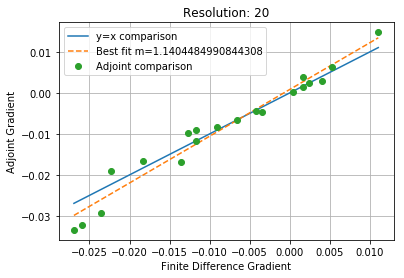

Starting forward run...
Starting adjoint run...
Calculating gradient...


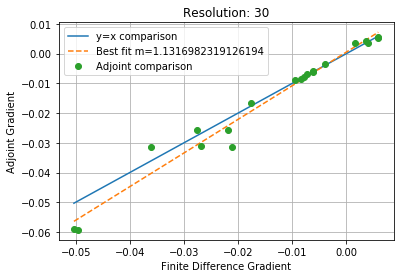

Starting forward run...
Starting adjoint run...
Calculating gradient...


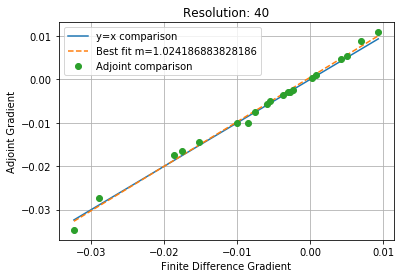

In [4]:
db = 1e-3
choose = 20

opt.objective_functions=[J1]
for resolution in [20,30,40]:
    opt.sim.resolution = resolution
    f0, dJ_deps, dg = opt()
    g_adjoint = np.sum(design_variables.get_basis_vjp(dJ_deps,dg), axis=1)
    g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)
    g_discrete = np.array(g_discrete)


    (m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
    min_g = np.min(g_discrete)
    max_g = np.max(g_discrete)
        
    plt.figure()
    plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
    plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
    plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
    plt.xlabel('Finite Difference Gradient')
    plt.ylabel('Adjoint Gradient')
    plt.title('Resolution: {}'.format(resolution))
    plt.legend()
    plt.grid(True)
    plt.show()

Starting forward run...
Starting adjoint run...


/usr/local/lib/python3.5/site-packages/meep/adjoint/filter_source.py:89: RuntimeWarning: invalid value encountered in true_divide
  l2_err = np.sum(np.abs(H-H_hat)**2/np.abs(H)**2)
/usr/local/lib/python3.5/site-packages/meep/adjoint/filter_source.py:89: RuntimeWarning: divide by zero encountered in true_divide
  l2_err = np.sum(np.abs(H-H_hat)**2/np.abs(H)**2)


Calculating gradient...


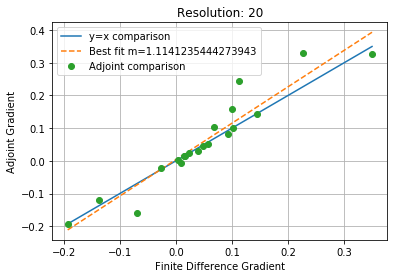

Starting forward run...
Starting adjoint run...
Calculating gradient...


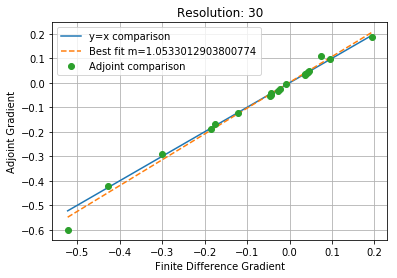

Starting forward run...
Starting adjoint run...
Calculating gradient...


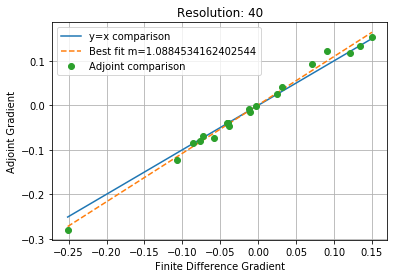

In [6]:
opt.objective_functions=[J2]
for resolution in [20,30,40]:
    opt.sim.resolution = resolution
    f0, dJ_deps, dg = opt()
    g_adjoint = np.sum(design_variables.get_basis_vjp(dJ_deps,dg), axis=1)
    g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)
    g_discrete = np.array(g_discrete)


    (m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
    min_g = np.min(g_discrete)
    max_g = np.max(g_discrete)
        
    plt.figure()
    plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
    plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
    plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
    plt.xlabel('Finite Difference Gradient')
    plt.ylabel('Adjoint Gradient')
    plt.title('Resolution: {}'.format(resolution))
    plt.legend()
    plt.grid(True)
    plt.show()

Starting forward run...
Starting adjoint run...
Calculating gradient...


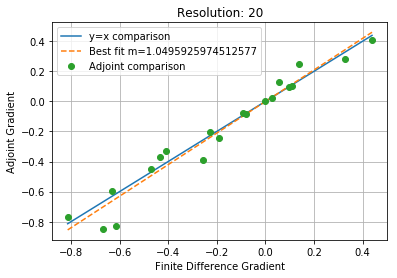

Starting forward run...
Starting adjoint run...
Calculating gradient...


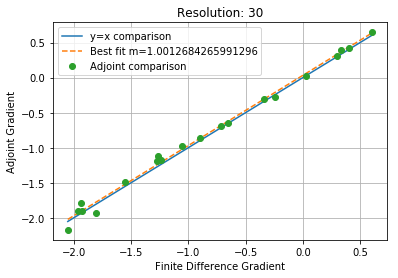

Starting forward run...
Starting adjoint run...
Calculating gradient...


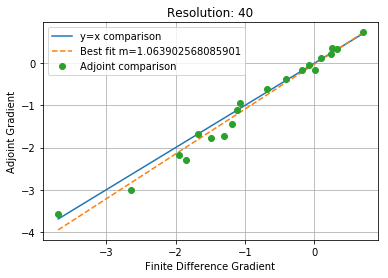

In [7]:
opt.objective_functions=[J3]
for resolution in [20,30,40]:
    opt.sim.resolution = resolution
    f0, dJ_deps, dg = opt()
    g_adjoint = np.sum(design_variables.get_basis_vjp(dJ_deps,dg), axis=1)
    g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)
    g_discrete = np.array(g_discrete)


    (m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
    min_g = np.min(g_discrete)
    max_g = np.max(g_discrete)
        
    plt.figure()
    plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
    plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
    plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
    plt.xlabel('Finite Difference Gradient')
    plt.ylabel('Adjoint Gradient')
    plt.title('Resolution: {}'.format(resolution))
    plt.legend()
    plt.grid(True)
    plt.show()